# Chlorophyll comparison

# import packages and functions

In [1]:
%cd '/Users/akbaskind/Documents/Python Scripts/phyto'
%run PLT.py

/Users/akbaskind/Documents/Python Scripts/phyto


In [2]:
from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter
import numpy as np
import xarray as xr
import pandas as pd
import scipy
from datetime import datetime, timedelta
import time
import seaborn
import matplotlib.dates as mdates
import bottleneck as bn
import PyCO2SYS as pyco2
import gsw
import math
import netCDF4 as nc
import requests
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

from importlib import reload
import warnings
warnings.filterwarnings('ignore')

# Pull data from [spreadsheet](https://docs.google.com/spreadsheets/d/1uLRAvFDsTSfS-c45DiG-W6VMa8I1J7XD1O-pJA4fp10/edit#gid=0)

- opening all the datasets in the spreadsheet all at once
- `hydrocat620`
- `hydrocat720`
- `MV`
- `QP`

In [3]:
#The scope is always look like this so we did not need to change anything

import gspread
from df2gspread import df2gspread as d2g
from oauth2client.service_account import ServiceAccountCredentials

scope = [
   'https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive']

# Name of our Service Account Key
google_key_file = 'servicecredentials.json'
credentials = ServiceAccountCredentials.from_json_keyfile_name(google_key_file, scope)
gc = gspread.authorize(credentials)

# Spreadsheet key
spreadsheet_key = '1uLRAvFDsTSfS-c45DiG-W6VMa8I1J7XD1O-pJA4fp10'

# Worksheet keys
wks_hydrocat620 = 'Hydrocat 620'
wks_hydrocat720 = 'Hydrocat 720'
wks_MV = 'MV'
wks_QP = 'QP'

#Opening the worksheet by using Worksheet ID
workbook = gc.open_by_key(spreadsheet_key)

## HYDROCAT 620
#Selecting which sheet to pulling the data
sheet = workbook.worksheet(wks_hydrocat620)
values = sheet.get_all_values()
hydrocat620 = pd.DataFrame(values[1:], columns = values[0])


## HYDROCAT 720
#Selecting which sheet to pulling the data
sheet = workbook.worksheet(wks_hydrocat720)
values = sheet.get_all_values()
hydrocat720 = pd.DataFrame(values[1:], columns = values[0])

## MV
#Selecting which sheet to pulling the data
sheet = workbook.worksheet(wks_MV)
values = sheet.get_all_values()
MV = pd.DataFrame(values[1:], columns = values[0])

## QP
#Selecting which sheet to pulling the data
sheet = workbook.worksheet(wks_QP)
values = sheet.get_all_values()
QP = pd.DataFrame(values[1:], columns = values[0])

## Correct data types

In [4]:
for k in hydrocat620.keys():
    if k == 'DateTime' or k == 'time':
        hydrocat620[k] = pd.to_datetime(hydrocat620[k])
    else:
        hydrocat620[k] = pd.to_numeric(hydrocat620[k])

for k in hydrocat720.keys():
    if k == 'DateTime' or k == 'time':
        hydrocat720[k] = pd.to_datetime(hydrocat720[k])
    else:
        hydrocat720[k] = pd.to_numeric(hydrocat720[k])
        
for k in QP.keys():
    if k == 'DateTime' or k == 'time':
        QP[k] = pd.to_datetime(QP[k])
    else:
        QP[k] = pd.to_numeric(QP[k])
        
for k in MV.keys():
    if k == 'DateTime' or k == 'time':
        MV[k] = pd.to_datetime(MV[k])
    else:
        MV[k] = pd.to_numeric(MV[k])

# Chlorophyll data

In [5]:
H620 = PLT.get_hydrocat('2021-01-01', '2023-06-10', 'PLT')

## Narragansett Bay Long Term Phytoplankton Time Series Chlorophyll data


In [5]:
chlavg = pd.read_csv('/Users/akbaskind/Desktop/Dissertation/PLT_chl_mmYYYY_avg.csv')
chlStd = pd.read_csv('/Users/akbaskind/Desktop/Dissertation/PLT_chl_mmYYYY_StD.csv')

In [6]:
chl = pd.read_csv('/Users/akbaskind/Desktop/Dissertation/PLT_chl.csv')
chl.drop(chl.head(2).index,inplace=True)
chl

,Sample Date,surface chla all,Surface Phaeo all,Bottom Chla all,Bottom Phaeo all,surface chla <20 um,Surface Phaeo <20 um,Bottom Chla <20 um,Bottom Phaeo <20 um
2,1999-01-25,3.72,0.80,3.26,1.15,NaN,NaN,NaN,NaN
3,1999-02-01,2.90,0.74,2.66,0.83,NaN,NaN,NaN,NaN
4,1999-02-08,2.20,0.94,3.24,1.98,NaN,NaN,NaN,NaN
5,1999-02-15,1.34,1.20,1.47,0.60,NaN,NaN,NaN,NaN
6,1999-02-22,12.56,5.33,9.04,4.97,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
1182,2023-02-12,4.65,2.47,3.32,3.24,0.64,1.73,0.51,1.96
1183,2023-02-21,1.44,2.46,1.69,2.63,0.60,1.93,0.74,2.06
1184,2023-03-07,0.91,1.60,1.31,1.78,0.57,1.24,0.81,1.40
1185,2023-03-12,1.27,1.14,1.33,1.36,0.92,1.18,0.89,0.75


In [7]:
for k in chlavg.keys():
    if k != 'Years' or k == 'time':
        chlavg[k] = pd.to_numeric(chlavg[k])
        # chl[k] = datetime.strptime(chl[k], "%Y-%m-%d")
for k in chlStd.keys():
    if k != 'Years' or k == 'time':
        chlStd[k] = pd.to_numeric(chlStd[k])
for k in chl.keys():
    if k == 'Sample Date':
        chl[k] = pd.to_datetime(chl[k])
    else:
        chl[k] = pd.to_numeric(chl[k])

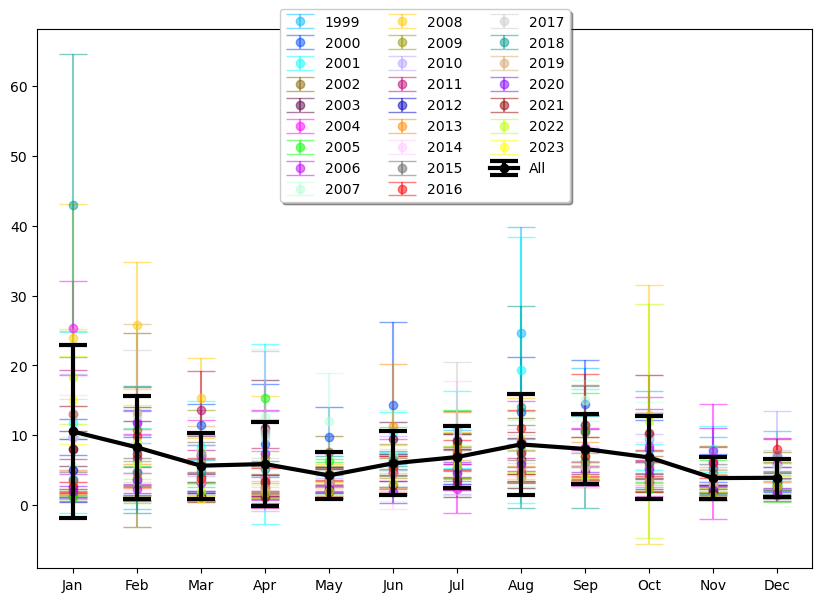

In [8]:
fig, ax = plt.subplots(figsize = [10,7])

clrs = ['#00B7FF', '#004DFF', '#00FFFF', '#826400', '#580041', 
        '#FF00FF', '#00FF00', '#C500FF', '#B4FFD7', '#FFCA00',
        '#969600', '#B4A2FF', '#C20078', '#0000C1', '#FF8B00', '#FFC8FF', 
        '#666666', '#FF0000', '#CCCCCC', '#009E8F', '#D7A870', '#8200FF', 
        '#960000', '#BBFF00', '#FFFF00', '#006F00']
mn = [10.54543783,8.273352355,5.64260223,5.87811563,4.243529762,5.980926261,6.879467488,8.694514432,8.033474519,6.819660069,3.866044071,3.906254811]
std = [12.34661618,7.378422619,4.723778638,6.050803222,3.355966725,4.58363387,4.412466291,7.270243505,4.99818224,5.932682415,3.00423971,2.731432223]
i = 0
for k in chlavg.keys():
    if k != 'Years':
        ax.errorbar(chlavg['Years'], chlavg[k], yerr = chlStd[k], marker = 'o', color = clrs[i], linestyle = 'none', alpha = 0.5, capsize=10, label = k)
        i += 1

ax.errorbar(chlavg['Years'], mn, yerr = std, marker = 'o', color = 'k', label = 'All', lw = 3, capsize = 10, capthick = 3, zorder = 3)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)

In [24]:
chl = chl.where(chl['Sample Date']>datetime(2022, 1, 1)).dropna()
chl = chl.reset_index(drop=True)
chl 

,Sample Date,surface chla all,Surface Phaeo all,Bottom Chla all,Bottom Phaeo all,surface chla <20 um,Surface Phaeo <20 um,Bottom Chla <20 um,Bottom Phaeo <20 um
0,2022-01-04,7.61,3.23,7.46,3.71,3.17,2.07,2.49,2.64
1,2022-01-10,17.55,2.00,16.97,3.31,6.63,2.60,3.43,2.95
2,2022-01-16,20.39,2.43,20.86,4.82,1.88,2.38,4.65,2.77
3,2022-01-24,26.17,5.30,19.34,5.99,2.52,2.39,4.74,3.40
4,2022-01-31,20.13,3.88,20.08,10.75,2.17,3.04,2.48,5.25
5,2022-02-07,15.24,4.47,14.77,5.63,3.26,5.07,2.15,3.55
6,2022-02-15,10.43,3.22,6.44,4.35,1.98,2.33,1.32,3.21
7,2022-02-21,2.50,4.31,2.18,3.96,0.99,2.90,0.74,2.84
8,2022-02-28,7.76,3.15,7.22,4.00,1.81,2.18,1.41,2.70
9,2022-03-07,1.15,1.73,1.40,2.10,0.59,1.54,0.79,1.74


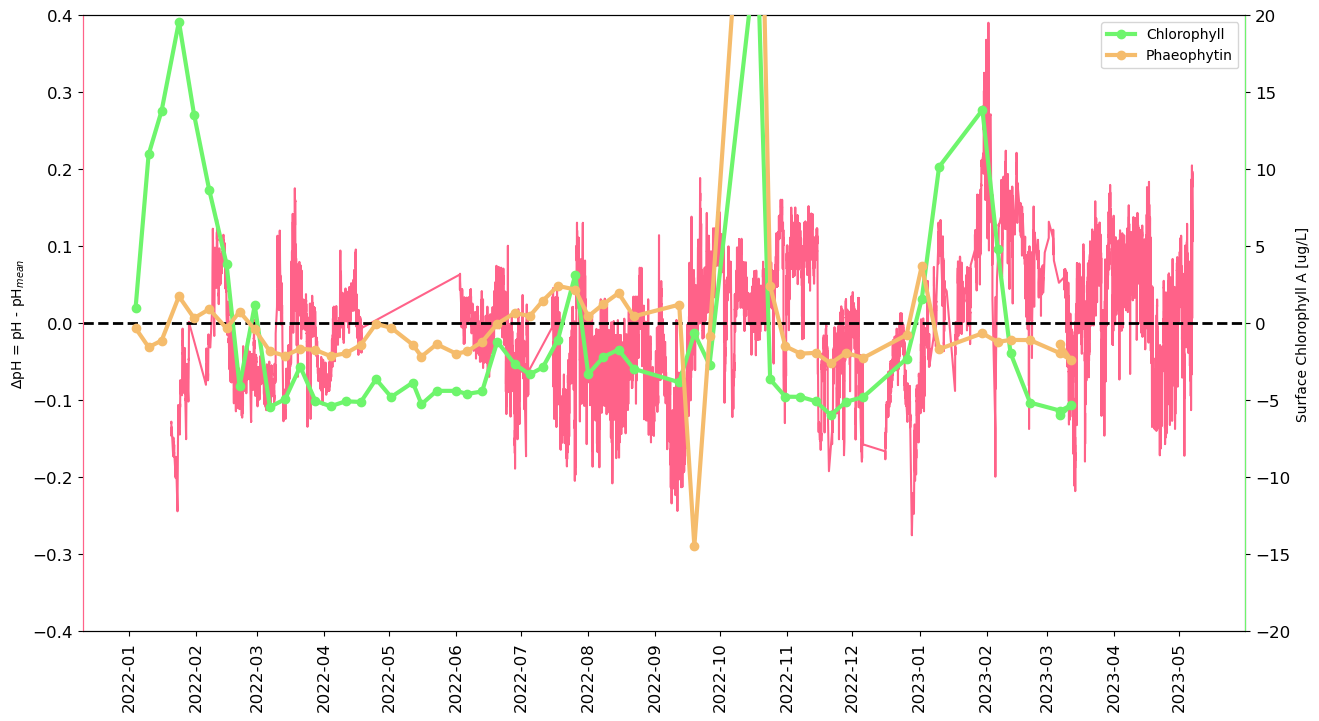

In [66]:
fig, ax2 = plt.subplots(figsize = [15,8])
anom = hydrocat620['adjusted_ph temp'] - hydrocat620['adjusted_ph temp'].mean()
# ax2.plot(hydrocat620['DateTime'], anom.where(anom >= 0), color = 'red')
# ax2.plot(hydrocat620['DateTime'], anom.where(anom <= 0), color = 'blue')
ax2.plot(hydrocat620['DateTime'], anom, color = '#ff6289')
ax2.spines['left'].set_color('#ff6289')
ax2.set_ylabel('∆pH = pH - pH$_{mean}$')
ax2.set_ylim([-0.4,0.4])
ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax2.tick_params('x',labelsize = 12, labelrotation = 90)
ax2.tick_params('y',labelsize = 12)

ax=ax2.twinx()
anom1 = chl['surface chla all'] - 6.58
anom2 = chl['Surface Phaeo all'] - chl['Surface Phaeo all'].mean()

ax.plot(chl['Sample Date'], anom1, marker = 'o', color = '#6ef56c', lw = 3, zorder = 3, label = 'Chlorophyll')
ax.plot(chl['Sample Date'], anom2, marker = 'o', color = '#f5bc6c', lw = 3, zorder = 3, label = 'Phaeophytin')
ax.legend()
ax.set_ylabel('Surface Chlorophyll A [ug/L]')
ax.set_ylim([-20,20])
ax.spines['right'].set_color('#6ef56c')
ax.spines['left'].set_color('#ff6289')
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.tick_params('x',labelsize = 12, labelrotation = 90)
ax.tick_params('y',labelsize = 12)

ax.axhline(y=0.0, color='k', linestyle='dashed', lw = 2)

In [64]:
chl.keys()

Index(['Sample Date', 'surface chla all', 'Surface Phaeo all',
       'Bottom Chla all', 'Bottom Phaeo all', 'surface chla <20 um',
       'Surface Phaeo <20 um', 'Bottom Chla <20 um', 'Bottom Phaeo <20 um'],
      dtype='object')

In [40]:
# 30683
15423+15260

30683

In [60]:
hydrocat620['adjusted_ph temp'].mean()

7.796873984983684